<a href="https://colab.research.google.com/github/ghaydakk/Machine-Learning/blob/main/Hate_Speech_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

url = 'http://edinburghnlp.inf.ed.ac.uk/workshops/OSACT4/datasets/OSACT2020-sharedTask-train.txt'
cols=['Tweet','OFF','HS']
data = pd.read_csv(url,encoding='utf-8',sep='\t',header =None, names=cols)
data.drop('HS',axis=1,inplace=True)

                                               Tweet      OFF
0  الحمدلله يارب فوز مهم يا زمالك.. كل الدعم ليكم...  NOT_OFF
1            فدوه يا بخت فدوه يا زمن واحد منكم يجيبه  NOT_OFF
2  RT @USER: يا رب يا واحد يا أحد بحق يوم الاحد ا...      OFF
3  RT @USER: #هوا_الحرية يا وجع قلبي عليكي يا امي...  NOT_OFF
4          يا بكون بحياتك الأهم يا إما ما بدي أكون 🎼  NOT_OFF


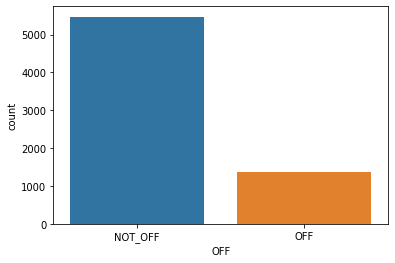

In [ ]:
print(data.head(5))
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x='OFF', data= data)

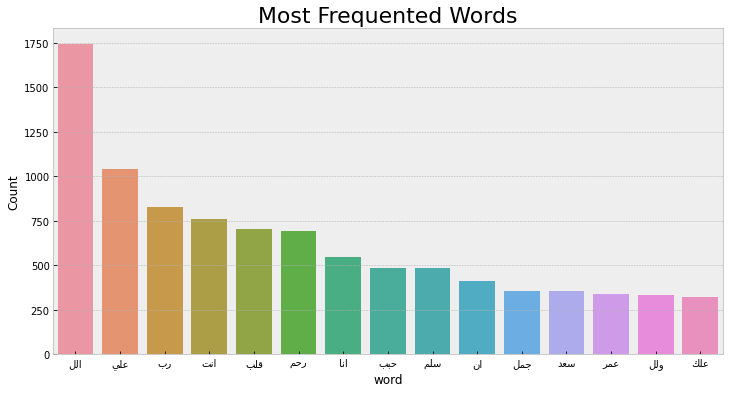

In [ ]:
Most_Frequented_Words(data)

In [ ]:
import re
# //////////////////Data Cleaning///////////////
arabic_diacritics = re.compile("""
                             ّ    | 
                             َ    | 
                             ً    | 
                             ُ    | 
                             ٌ    | 
                             ِ    | 
                             ٍ    | 
                             ْ    | 
                             ـ     
                         """, re.VERBOSE)

def preprocess(new_text):
        new_text = re.sub('<.*?>', '', new_text)   # remove HTML tags
        new_text = re.sub(r'[^\w\s]', '', new_text) # remove punc.
        new_text = re.sub(r'\d+','',new_text)# remove numbers
        new_text = re.sub("[إأآا]", "ا", new_text) # normalization
        new_text = re.sub("ى", "ي", new_text)
        new_text = re.sub("ؤ", "ء", new_text)
        new_text = re.sub("ئ", "ء", new_text)
        new_text = re.sub("ة", "ه", new_text)
        new_text = re.sub("گ", "ك", new_text)
        new_text = re.sub("ض", "ظ", new_text)
        new_text = re.sub(arabic_diacritics, '', new_text)
        new_text = re.sub('@','',new_text)
        new_text = re.sub(r'[a-zA-Z]', '', new_text)
        new_text = re.sub('_','',new_text)         
        return new_text


data['Tweet']= data['Tweet'].apply(lambda x: preprocess(x))

In [ ]:
data.head()

,Tweet,OFF
0,الحمدلله يارب فوز مهم يا زمالك كل الدعم ليكم ي...,NOT_OFF
1,فدوه يا بخت فدوه يا زمن واحد منكم يجيبه,NOT_OFF
2,يا رب يا واحد يا احد بحق يوم الاحد ان تهلك ب...,OFF
3,هواالحريه يا وجع قلبي عليكي يا اميالله لا يح...,NOT_OFF
4,يا بكون بحياتك الاهم يا اما ما بدي اكون,NOT_OFF


In [ ]:
# //////////////////Stemming///////////////
import nltk
nltk.download('punkt')
from nltk import word_tokenize
from nltk.stem.isri import ISRIStemmer
stemmer = ISRIStemmer()
data['Tweet']=data['Tweet'].apply(word_tokenize)
data['Tweet']=data['Tweet'].apply(lambda x : [stemmer.stem(y) for y in x])
data['Tweet']=data['Tweet'].apply(lambda x : " ".join(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# //////////////////Stopwords///////////////
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
stop = stopwords.words('arabic')
data['Tweet']=data['Tweet'].apply(word_tokenize)
data['Tweet']=data['Tweet'].apply(lambda x: [item for item in x if item not in stop])
data['Tweet']=data['Tweet'].apply(lambda x : " ".join(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize

cv = CountVectorizer(ngram_range=(1,1),tokenizer=word_tokenize)
text_counts= cv.fit_transform(data['Tweet'])
text_counts

<6839x10860 sparse matrix of type '<class 'numpy.int64'>'
	with 75178 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
data['OFF'] = lb.fit_transform(data['OFF'])

In [ ]:
#Shuffling 
data = data.sample(frac=1)

#Data splitting
x_train,x_test,y_train,y_test=train_test_split(text_counts,data['OFF'],test_size=.3)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


def build_cf_matrics(cf_matrix,classifier_name):
  group_names = ['TN','FP','FN','TP']

  group_counts = ['{0:0.0f}'.format(value) for value in
                  cf_matrix.flatten()]

  group_percentages = ['{0:.2%}'.format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]

  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]

  labels = np.asarray(labels).reshape(2,2)

  sns.heatmap(cf_matrix, annot=labels,
              annot_kws={"size": 22},
              fmt='', cmap='Spectral') 
  plt.gcf().set_size_inches(9,6)
  plt.title(classifier_name,size=22)
  return plt.show()

In [ ]:
def MLmodel(classifier_used,classifier_name):
  print('************',classifier_name,'***************')
  classifier_ = classifier_used
  classifier_result = classifier_.fit(x_train,y_train)
  y_pred = classifier_result.predict(x_test)
  print(classification_report(y_test,y_pred))
  cf_matrix = confusion_matrix(y_test,y_pred)
  build_cf_matrics(cf_matrix,classifier_name)

************ Random Forest Classifier ***************
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      1677
           1       0.28      0.08      0.12       375

    accuracy                           0.79      2052
   macro avg       0.55      0.52      0.50      2052
weighted avg       0.72      0.79      0.74      2052



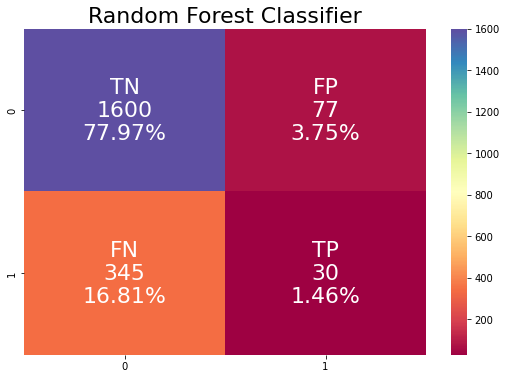

In [ ]:
from sklearn.ensemble import RandomForestClassifier
MLmodel(RandomForestClassifier(),'Random Forest Classifier')

************ Naive-Bayes Classifier ***************
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1677
           1       0.17      0.09      0.12       375

    accuracy                           0.75      2052
   macro avg       0.49      0.50      0.49      2052
weighted avg       0.70      0.75      0.72      2052



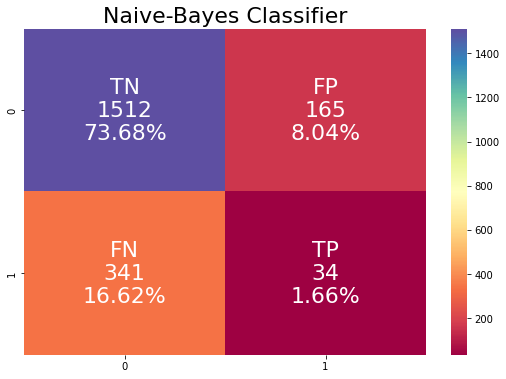

In [ ]:
from sklearn.naive_bayes import MultinomialNB
MLmodel(MultinomialNB(), 'Naive-Bayes Classifier')

************ KNeighbors Classifier ***************
              precision    recall  f1-score   support

           0       0.79      0.94      0.86      1623
           1       0.25      0.08      0.12       429

    accuracy                           0.76      2052
   macro avg       0.52      0.51      0.49      2052
weighted avg       0.68      0.76      0.70      2052



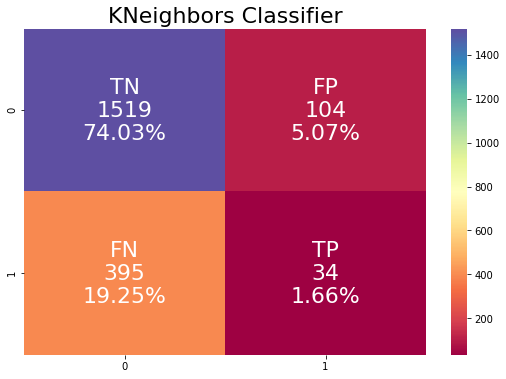

In [ ]:
from sklearn.neighbors import  KNeighborsClassifier
MLmodel(KNeighborsClassifier(),'KNeighbors Classifier')

************ Decision Tree Classifier ***************
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1623
           1       0.23      0.15      0.18       429

    accuracy                           0.72      2052
   macro avg       0.51      0.51      0.51      2052
weighted avg       0.68      0.72      0.69      2052



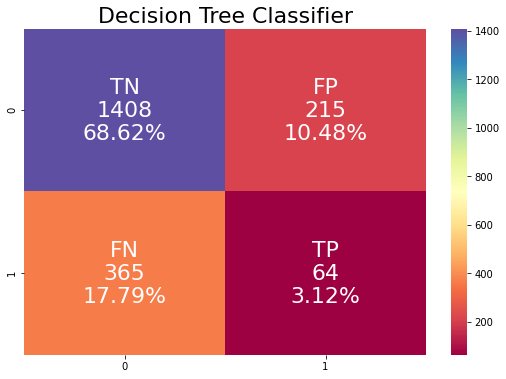

In [ ]:
from sklearn.tree import  DecisionTreeClassifier
MLmodel(DecisionTreeClassifier(),'Decision Tree Classifier')

************ Logistic Regression Classifier ***************
              precision    recall  f1-score   support

           0       0.79      0.93      0.86      1623
           1       0.20      0.06      0.09       429

    accuracy                           0.75      2052
   macro avg       0.49      0.50      0.47      2052
weighted avg       0.67      0.75      0.70      2052



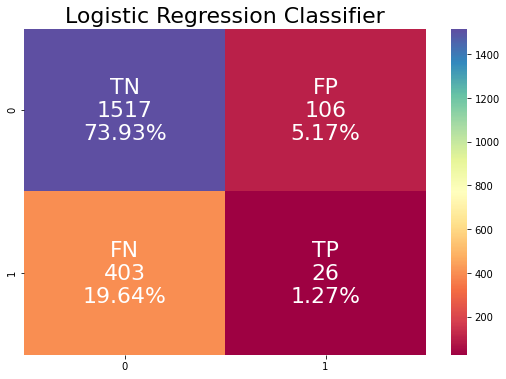

In [ ]:
from sklearn.linear_model import  LogisticRegression
MLmodel(LogisticRegression(),'Logistic Regression Classifier')

************  SVC Classifier ***************
              precision    recall  f1-score   support

           0       0.79      0.86      0.83      1623
           1       0.21      0.14      0.16       429

    accuracy                           0.71      2052
   macro avg       0.50      0.50      0.50      2052
weighted avg       0.67      0.71      0.69      2052



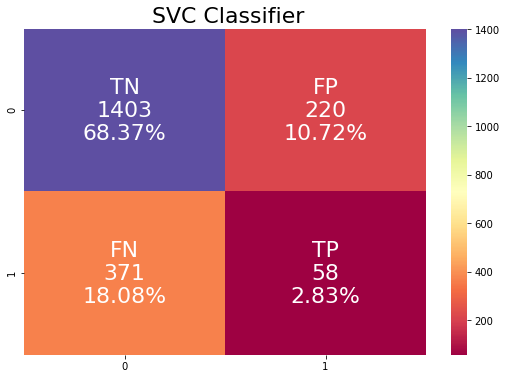

In [ ]:
from sklearn.svm import SVC
MLmodel(SVC(kernel='linear'), ' SVC Classifier')

************ Voting Classifier ***************
              precision    recall  f1-score   support

           0       0.79      0.99      0.88      1630
           1       0.14      0.01      0.01       422

    accuracy                           0.79      2052
   macro avg       0.46      0.50      0.45      2052
weighted avg       0.66      0.79      0.70      2052



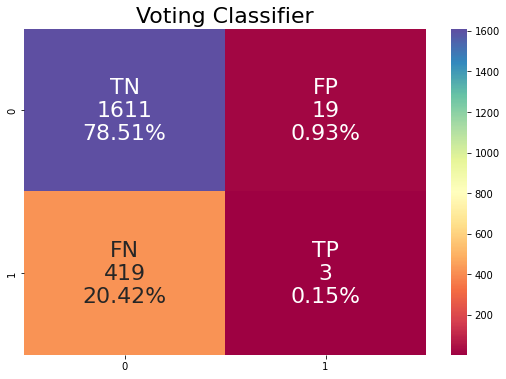


***********
Accuracy is: 0.7865497076023392
Log Loss is: 7.372319324231021
F1 Score is: 0.013513513513513514


In [ ]:
from sklearn.metrics import accuracy_score, log_loss, f1_score
from sklearn.ensemble import VotingClassifier

from sklearn.linear_model import  LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

model1 = LogisticRegression()
model2 = RandomForestClassifier()
model3 = KNeighborsClassifier()
model4 = MultinomialNB()
model = VotingClassifier(estimators=[('lr', model1), ('rf', model2), ('kn', model3),('nb', model4)], voting='soft')
model.fit(x_train,y_train)

y_pred = model.predict(x_test)
acc = accuracy_score(y_test, y_pred)
l_loss = log_loss(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print('************ Voting Classifier ***************')
print(classification_report(y_test,y_pred))
cf_matrix = confusion_matrix(y_test, y_pred)
build_cf_matrics(cf_matrix,'Voting Classifier')
print()
print('***********')
print("Accuracy is: " + str(acc))
print("Log Loss is: " + str(l_loss))
print("F1 Score is: " + str(f1))

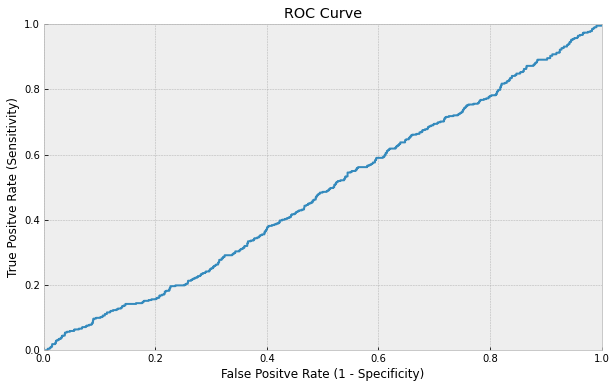

0.48308885529032064


In [ ]:

plt.style.use('bmh')
y_pred_prob=model.predict_proba(x_test)[:,1]

from sklearn.preprocessing import binarize

fqr , tqr, thresholds= metrics.roc_curve(y_test,y_pred_prob)
plt.plot(fqr,tqr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False Positve Rate (1 - Specificity)')
plt.ylabel('True Positve Rate (Sensitivity)')
plt.grid(True)
plt.gcf().set_size_inches(10,6)
plt.title('ROC Curve')
plt.show()

auc = metrics.roc_auc_score(y_test,y_pred_prob)
print(auc)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(ngram_range=(1,1),tokenizer=word_tokenize)
text_tf_idf= tf_idf.fit_transform(data['Tweet'])
text_tf_idf

<6839x10860 sparse matrix of type '<class 'numpy.float64'>'
	with 75178 stored elements in Compressed Sparse Row format>

In [ ]:
#Data splitting
x_train,x_test,y_train,y_test=train_test_split(text_tf_idf,data['OFF'],test_size=.3)

************ Random Forest Classifier ***************
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1658
           1       0.86      0.48      0.62       394

    accuracy                           0.89      2052
   macro avg       0.88      0.73      0.78      2052
weighted avg       0.88      0.89      0.87      2052



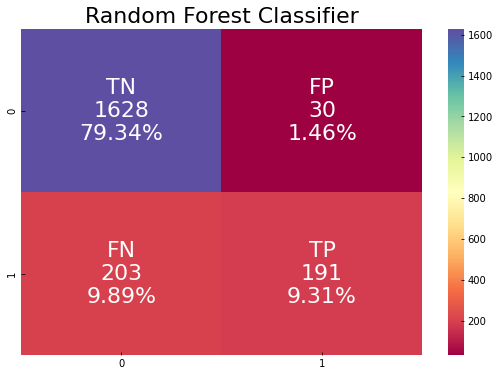

In [ ]:
from sklearn.ensemble import RandomForestClassifier
MLmodel(RandomForestClassifier(),'Random Forest Classifier')

************ Naive-Bayes Classifier ***************
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1658
           1       1.00      0.16      0.28       394

    accuracy                           0.84      2052
   macro avg       0.92      0.58      0.59      2052
weighted avg       0.87      0.84      0.79      2052



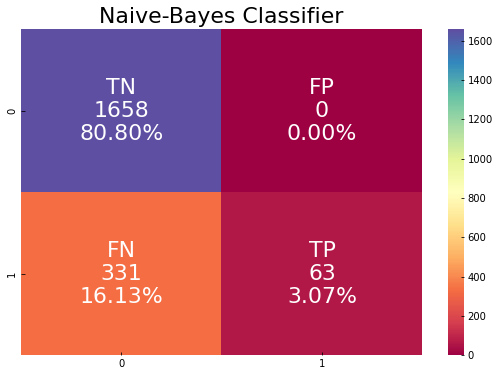

In [ ]:
from sklearn.naive_bayes import MultinomialNB
MLmodel(MultinomialNB(), 'Naive-Bayes Classifier')

************ KNeighbors Classifier ***************
              precision    recall  f1-score   support

           0       0.81      1.00      0.89      1658
           1       1.00      0.01      0.01       394

    accuracy                           0.81      2052
   macro avg       0.90      0.50      0.45      2052
weighted avg       0.85      0.81      0.72      2052



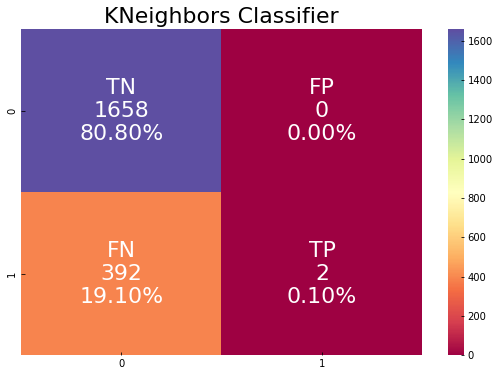

In [ ]:
from sklearn.neighbors import  KNeighborsClassifier
MLmodel(KNeighborsClassifier(),'KNeighbors Classifier')

************ Decision Tree Classifier ***************
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1658
           1       0.65      0.61      0.63       394

    accuracy                           0.86      2052
   macro avg       0.78      0.77      0.77      2052
weighted avg       0.86      0.86      0.86      2052



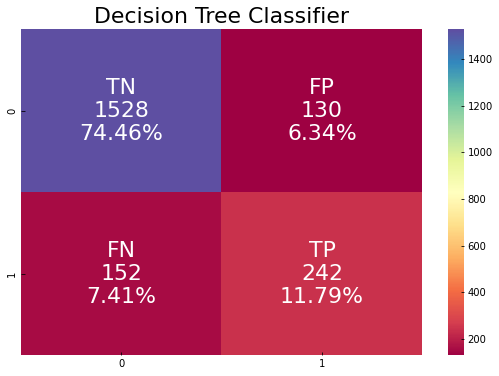

In [ ]:
from sklearn.tree import  DecisionTreeClassifier
MLmodel(DecisionTreeClassifier(),'Decision Tree Classifier')

************ Logistic Regression Classifier ***************
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      1658
           1       0.98      0.30      0.46       394

    accuracy                           0.86      2052
   macro avg       0.92      0.65      0.69      2052
weighted avg       0.88      0.86      0.83      2052



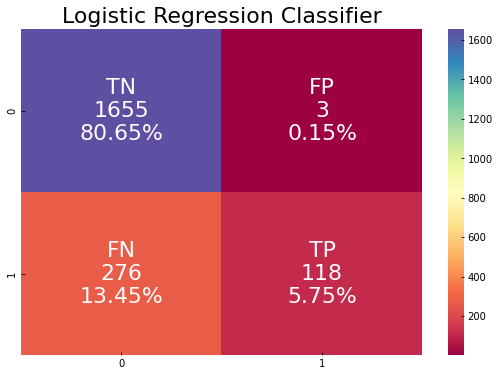

In [ ]:
from sklearn.linear_model import  LogisticRegression
MLmodel(LogisticRegression(),'Logistic Regression Classifier')

************  SVC Classifier ***************
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      1658
           1       0.89      0.52      0.65       394

    accuracy                           0.90      2052
   macro avg       0.89      0.75      0.80      2052
weighted avg       0.90      0.90      0.88      2052



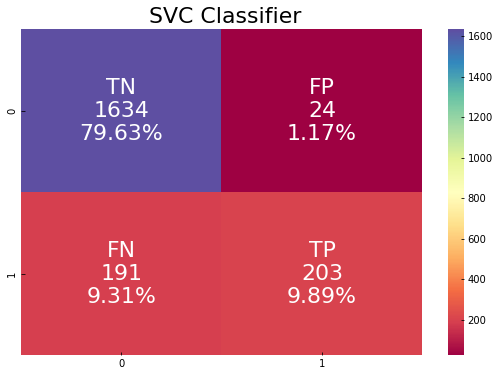

In [ ]:
from sklearn.svm import SVC
MLmodel(SVC(kernel='linear'), ' SVC Classifier')

************ Voting Classifier ***************
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1658
           1       0.99      0.19      0.32       394

    accuracy                           0.84      2052
   macro avg       0.91      0.59      0.62      2052
weighted avg       0.87      0.84      0.80      2052



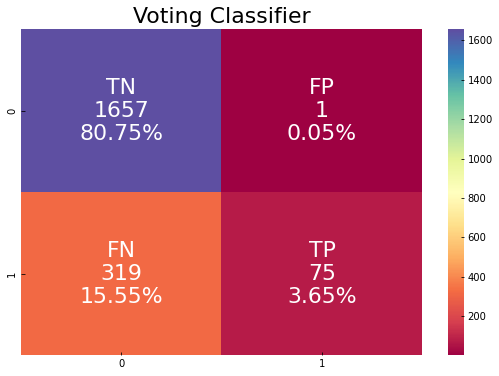


***********
Accuracy is: 0.8440545808966862
Log Loss is: 5.386164349887355
F1 Score is: 0.3191489361702128


In [ ]:
from sklearn.metrics import accuracy_score, log_loss, f1_score
from sklearn.ensemble import VotingClassifier
model1 = LogisticRegression()
model2 = RandomForestClassifier()
model3 = KNeighborsClassifier()
model4 = MultinomialNB()
model = VotingClassifier(estimators=[('lr', model1), ('rf', model2), ('kn', model3),('nb', model4)], voting='soft')
model.fit(x_train,y_train)

y_pred = model.predict(x_test)
acc = accuracy_score(y_test, y_pred)
l_loss = log_loss(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print('************ Voting Classifier ***************')
print(classification_report(y_test,y_pred))
cf_matrix = confusion_matrix(y_test, y_pred)
build_cf_matrics(cf_matrix,'Voting Classifier')
print()
print('***********')
print("Accuracy is: " + str(acc))
print("Log Loss is: " + str(l_loss))
print("F1 Score is: " + str(f1))

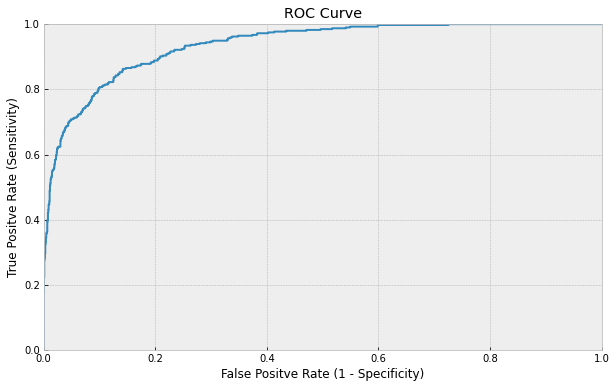

0.9362611978225862


In [ ]:
plt.style.use('bmh')
y_pred_prob=model.predict_proba(x_test)[:,1]

from sklearn.preprocessing import binarize

fqr , tqr, thresholds= metrics.roc_curve(y_test,y_pred_prob)
plt.plot(fqr,tqr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False Positve Rate (1 - Specificity)')
plt.ylabel('True Positve Rate (Sensitivity)')
plt.grid(True)
plt.gcf().set_size_inches(10,6)
plt.title('ROC Curve')
plt.show()

auc = metrics.roc_auc_score(y_test,y_pred_prob)
print(auc)

In [ ]:
!pip install arabic_reshaper
!pip install python-bidi

In [ ]:
def Most_Frequented_Words(df):
  from nltk.corpus import stopwords
  from nltk import word_tokenize
  import matplotlib.pyplot as plt
  import seaborn as sns

  import arabic_reshaper
  from bidi.algorithm import get_display

  stop = stopwords.words('arabic')
  df['Tweet']=df['Tweet'].apply(word_tokenize)
  df['Tweet']=df['Tweet'].apply(lambda x: [item for item in x if item not in stop])
  df['Tweet']=df['Tweet'].apply(lambda x : " ".join(x))

  freq_most_pos = pd.Series(' '.join(df['Tweet']).split()).value_counts()[:15]
  freq_most_pos = {get_display(arabic_reshaper.reshape(k)): v for k,v in freq_most_pos.items()}
  most_pos_df=pd.DataFrame(freq_most_pos.items(), columns=['word', 'count'])

  plt.figure(figsize=(12,6))
  ax = sns.barplot(data=most_pos_df, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.title('Most Frequented Words',size=22)
  return plt.show()

def Classes_Counts(df):
  df.OFF.value_counts()
  OFF_count=df.groupby('OFF').count()
  plt.bar(OFF_count.index.values, OFF_count['Tweet'])
  plt.xlabel('classes')
  plt.ylabel('Count')
  plt.show()

  positive_data = df[df['OFF'] == 'NOT_OFF']
  positive_data = positive_data['Tweet']
  nagitive_data = df[df['OFF'] == 'OFF']
  nagitive_data = nagitive_data['Tweet']

  print('Counts of NOT-OFF Tweets',positive_data.count()) #5468
  print('Counts of OFF Tweets',nagitive_data.count()) #1371    >> both  6839
